<a href="https://colab.research.google.com/github/van-dang/FEniCS-Colab/blob/master/Wave2D_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kiến thức nền tảng

In [0]:
# This demo adapts an existing code to solve the Poisson equation
# The orignal code is available here: https://fenicsproject.org/tutorial/

"""
FEniCS tutorial demo program: Poisson equation with Dirichlet conditions.
Test problem is chosen to give an exact solution at all nodes of the mesh.

  -Laplace(u) = f    in the unit square
            u = u_D  on the boundary

  u_D = 1 + x^2 + 2y^2
    f = -6
"""

# Original code is available at https://fenicsproject.org/tutorial/


Phương trình Poisson được định nghĩa trên một miền tính toán $\Omega$ có dạng như sau:

$$-\Delta u=f$$

Phương trình cần được bổ sung với một hoặc vài điều kiện trên biên $\partial \Omega$. Ở đây giả sử điều kiện Dirichlet được sử dụng

$$u = u_D \text{ on } \partial \Omega$$

Để kiểm tra tính chính xác của việc cài đặt thuật toán, người ta thường giả sử nghiệm đã biết trước là hàm $u_e$ nào đó. Giả sử $u_e=1 + x^2 + 2\,y^2$, ta có thể tính được nguồn $f=-\Delta u_e=-6$ và trên biên thì $u_D=u_e$.

Để giải phương trình, người ta cần biết sẽ tìm nghiệm ở đâu. Vì vậy, không gian hàm cần được định nghĩa. Trước hết mình chọn không gian hàm cho nghiệm cần tìm (trial function space) 

$$V=\Biggl\{u:\Omega\to\mathbb{R}\,\Biggl| \,\int\limits_\Omega u^2 + |\nabla u|^2\,d\Omega<\infty, u=u_D\text{ on }\partial \Omega\Biggl\}$$

Nghiệm của PPPTHH là nghiệm yếu (weak solution), vì vậy người ta cần chọn thêm không gian hàm kiểm tra (test function space)

$$\hat{V}=\Biggl\{v:\Omega\to\mathbb{R}\,\Biggl| \,\int\limits_\Omega v^2 + |\nabla v|^2\,d\Omega<\infty, v=0\text{ on }\partial \Omega\Biggl\}$$

Muốn tìm nghiệm $u$ trong trial function space $V$, đầu tiên, người ta nhân 2 vế của phương trình Poisson với một test function $v\in \hat{V}$ và lấy tích phân trên $\Omega$

$$\displaystyle -\int\limits_{\Omega} \Delta u\, v\, d\Omega= \int\limits_{\Omega} f\, v\, d\Omega.$$

Áp dụng công thức Green thứ nhất, i. e.

$$\displaystyle \int\limits_{\Omega} \Delta u\, v\, d\Omega=\int\limits_{\partial\Omega} \nabla u\cdot \mathbf{n}\, v\, ds - \int\limits_{\Omega} \nabla u \cdot\nabla v\, d\Omega,$$

Do định nghĩa của $\hat{V}$, cụm liên quan đến biên bị triệt tiêu

$$\displaystyle \int\limits_{\Omega} \nabla u \cdot\nabla v\, d\Omega=\int\limits_{\Omega} f\, v\, d\Omega$$.


PPPTHH được diễn đạt như sau: Tìm $u\in V$ sao cho

$$a(u,v)=L(v)$$ cho tất cả $v\in \hat{V}$. Ở đây 

$\displaystyle a(u,v)=\int\limits_{\Omega} \nabla u \cdot\nabla v\, d\Omega$ được gọi là bilinear form.


$\displaystyle L(v)=\int\limits_{\Omega} f\, v\, d\Omega$ được gọi là linear form.

Chú ý không gian hàm trên đây là liên tục và vô hạn chiều. Người ta muốn tìm nghiệm xấp xỉ trên không gian hữu hạn chiều.

# Setting a working environment with FEniCS

In [4]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

dolfin version: 2018.1.0


# A wave solver

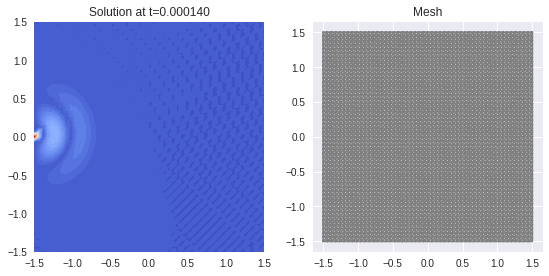

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


In [0]:
def plot_compact(u, t, stepcounter, QQ, pl, ax): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("Solution at t=%f" % (t)) # Plot norm of velocity
    if t == 0.: plt.axis(G); # plt.colorbar(pp, shrink=0.5); 
    plt.subplot(1, 2, 2);
    if t == 0.: plot(QQ.mesh()); plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

solver = KrylovSolver("gmres")
solver.parameters["relative_tolerance"] = 5e-6
solver.parameters["maximum_iterations"] = 1000
solver.parameters["monitor_convergence"] = True


# Source https://fenicsproject.org/qa/8883/wave-propagation-from-a-source-point/
# Adapted to Google Colab by Van-Dang Nguyen 

XMIN, XMAX = -1.5, 1.5;
YMIN, YMAX = -1.5, 1.5;
G = [XMIN, XMAX, YMIN, YMAX];

c=5000
mesh = RectangleMesh(Point(XMIN, YMIN), Point(XMAX, YMAX),50,50)
V=FunctionSpace(mesh, "Lagrange", 1)

# Time variables
dt = 0.000004; t = 0; T = 0.001

# Previous and current solution
u1= interpolate(Constant(0.0), V)
u0= interpolate(Constant(0.0), V)

# Variational problem at each time
u = TrialFunction(V)
v = TestFunction(V)

a = u*v*dx + dt*dt*c*c*inner(grad(u), grad(v))*dx
L = 2*u1*v*dx-u0*v*dx

bc = DirichletBC(V, 0, "on_boundary")
A, b = assemble_system(a, L, bc)

pl, ax = None, None; 
stepcounter = 0;
u=Function(V);

while t <= T:
    A, b = assemble_system(a, L, bc)
    delta = PointSource(V, Point(-1.5, 0.0), sin(c * 10 * t))
    delta.apply(b)
    solve(A, u.vector(), b)
    u0.assign(u1)
    u1.assign(u)
    pl, ax=plot_compact(u1, t, stepcounter, V, pl, ax)
    stepcounter += 1;
    t += dt